# PINN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE import lhs
from scipy.interpolate import griddata
import matplotlib.animation as animation

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
class PINN(nn.Module):
    def __init__(self, x_u, u, x_f, nu, lb, ub, layers):
        super(PINN, self).__init__()
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        self.x_u = torch.tensor(x_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(x_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(x_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(x_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)

        self.nu = nu
        self.layers = layers

        self.fc = self.initialize_nn(layers)

        self.to(device)

    def initialize_nn(self, layers):
        modules = []
        for i in range(1, len(layers) - 1):
            modules.append(nn.Linear(layers[i-1], layers[i]))
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layers[-2], layers[-1]))
        return nn.Sequential(*modules)
    
    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        u = self.fc(X)
        return u
    
    def pde_loss(self, x, t):
        u = self.forward(x, t)
        u_x = torch.autograd.grad(u, x, 
                                  grad_outputs=torch.ones_like(u), 
                                  retain_graph=True,
                                  create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, 
                                   grad_outputs=torch.ones_like(u_x), 
                                   retain_graph=True,
                                   create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, 
                                  grad_outputs=torch.ones_like(u), 
                                  retain_graph=True,
                                  create_graph=True)[0]

        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def initial_condition_loss(self):
        u0_pred = self.forward(self.x_f, torch.zeros_like(self.x_f))
        u0_true = torch.tensor(self.predict(self.x_f, self.t_f), requires_grad=True).to(device)
        return torch.mean((u0_pred - u0_true)**2)
    
    def train(self, nIter):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for epoch in range(nIter):
            optimizer.zero_grad()
            pde_loss = self.pde_loss(self.x_u, self.t_u)
            ic_loss = self.initial_condition_loss()
            loss = pde_loss + ic_loss
            loss.sum().backward()
            optimizer.step()

            if epoch % 100 == 0 and epoch > 0:
                print(f'Epoch {epoch}')

    def predict(self, x, t):
        x = torch.tensor(x).clone().detach().requires_grad_(True).float().to(device)
        t = torch.tensor(t).clone().detach().requires_grad_(True).float().to(device)
        return self.forward(x, t).detach().cpu().numpy()

In [3]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

FileNotFoundError: [Errno 2] No such file or directory: 'data/burgers_shock.mat'

In [5]:
print(X_star.shape)

(25600, 2)


In [52]:
model = PINN(X_u_train, u_train, X_f_train, nu, lb, ub, layers)

nIter = 1000
model.train(nIter)

<ipython-input-50-b04fb9bcb7ee>:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x).clone().detach().requires_grad_(True).float().to(device)
<ipython-input-50-b04fb9bcb7ee>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t).clone().detach().requires_grad_(True).float().to(device)


Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900


In [53]:
u_pred = model.predict(X_star[:, 0:1], X_star[:, 1:2])
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

c:\Users\Administrator\anaconda3\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


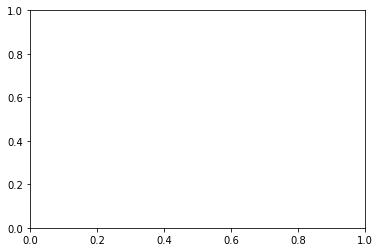

In [72]:
fig, ax = plt.subplots()

def init():
    ax.clear()
    ax.set_xlim(0, 100)  # Adjust the x-axis limits as needed
    ax.set_ylim(np.min(U_pred), np.max(U_pred))  # Adjust the y-axis limits as needed
    return

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    ax.plot(U_pred[frame])
    ax.set_title(f'Time Step: {frame}')
    ax.set_xlim(0, 100)  # Adjust the x-axis limits as needed
    ax.set_ylim(np.min(U_pred), np.max(U_pred))  # Adjust the y-axis limits as needed
    return

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(256), init_func=init, blit=False, repeat=False)

plt.show()

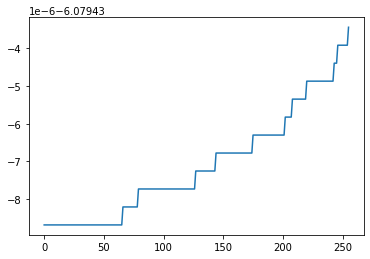

In [65]:
plt.plot(U_pred[10])